In [20]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Dropout
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4238901812500348296
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1069809230509772648
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6305113703
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7358094475585479371
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 687734784
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13751932361481542330
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:42:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18092732439384874952
physical_device_desc: "device: XLA_GPU device"
, name: "/dev

In [3]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 
                       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL',
                       'TRUE_TCHDL', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
print(VIEW_sub_df.shape)
print(VIEW_sub_df.isnull().sum())

(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')
(2099160, 33)
STUDENT_INDEX_MASTER          0
DATE                          0
QUARTERS                      0
AGE                           0
ETHNICITY                     0
SEX                      

In [4]:
print(VIEW_sub_df.shape)
ground_truth_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_y.csv')
print(ground_truth_df.shape)
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ground_truth_df.STUDENT_INDEX_MASTER)]
print(VIEW_sub_df.shape)

(2099160, 33)
(571480, 33)
(571480, 33)


In [5]:
print("ETHNICITY", VIEW_sub_df.ETHNICITY.unique())
print("SEX", VIEW_sub_df.SEX.unique())
print("NZDEP", VIEW_sub_df.NZDEP.unique())
print("SMOKING", VIEW_sub_df.SMOKING.unique())
print("HX_DIABETES", VIEW_sub_df.HX_DIABETES.unique())
print("FAMILY_HISTORY", VIEW_sub_df.FAMILY_HISTORY.unique())
print("HX_CVD", VIEW_sub_df.HX_CVD.unique())
print("GEN_LIPID", VIEW_sub_df.GEN_LIPID.unique())
print("RENAL", VIEW_sub_df.RENAL.unique())

ETHNICITY ['E' 'A' 'B' 'C' 'H' 'G' 'D' 'F']
SEX ['F' 'M']
NZDEP [4 1 3 5 2]
SMOKING [0. 1. 3. 4. 5. 2.]
HX_DIABETES [0. 1.]
FAMILY_HISTORY [1. 0.]
HX_CVD [0. 1.]
GEN_LIPID [0. 1. 4. 2. 3.]
RENAL [nan  0.  1.  2.  3.]


In [6]:
# find number of nan in SMOKING and RENAL
print(VIEW_sub_df.SMOKING.isnull().sum())
print(VIEW_sub_df.RENAL.isnull().sum())
print(VIEW_sub_df.HX_DIABETES_YR.isnull().sum())

0
355880
348208


In [7]:
# remove individuals that 
# contains nans in DBP2, SMOKING, EN_TCHDL
print(VIEW_sub_df.shape)
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['DBP2'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['SMOKING'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['EN_TCHDL'])]
print(VIEW_sub_df.shape)

(571480, 33)
(571480, 33)


In [8]:
# Count size of ethnicity groups
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'D'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'F'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'G'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H'].shape[0]//28)

3445
3434
3404
1177
3324
48
2187
3391


In [8]:
# Combine D, F and G
VIEW_sub_A_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A']
VIEW_sub_B_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B']
VIEW_sub_C_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C']
VIEW_sub_D_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY.isin(['D', 'F', 'G'])] # MELAA, Other and Other_Asian
VIEW_sub_E_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E']
VIEW_sub_H_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H']
print(VIEW_sub_A_df.shape[0]//28)
print(VIEW_sub_B_df.shape[0]//28)
print(VIEW_sub_C_df.shape[0]//28)
print(VIEW_sub_D_df.shape[0]//28)
print(VIEW_sub_E_df.shape[0]//28)
print(VIEW_sub_H_df.shape[0]//28)

3445
3434
3404
3412
3324
3391


In [11]:
print(VIEW_sub_A_df._is_view)
print(VIEW_sub_B_df._is_view)
print(VIEW_sub_C_df._is_view)
print(VIEW_sub_D_df._is_view)
print(VIEW_sub_E_df._is_view)
print(VIEW_sub_H_df._is_view)

False
False
False
False
False
False


In [12]:
# stratified random sampling unique ID 
# to control ethn imbalance
ethn_A_list = VIEW_sub_A_df.STUDENT_INDEX_MASTER.unique()
ethn_B_list = VIEW_sub_B_df.STUDENT_INDEX_MASTER.unique()
ethn_C_list = VIEW_sub_C_df.STUDENT_INDEX_MASTER.unique()
ethn_D_list = VIEW_sub_D_df.STUDENT_INDEX_MASTER.unique()
ethn_E_list = VIEW_sub_E_df.STUDENT_INDEX_MASTER.unique()
ethn_H_list = VIEW_sub_H_df.STUDENT_INDEX_MASTER.unique()
ethn_A_sample = list(np.random.choice(ethn_A_list, 3500, replace=False))
ethn_B_sample = list(np.random.choice(ethn_B_list, 3500, replace=False)) # over sample Europeans
ethn_C_sample = list(np.random.choice(ethn_C_list, 3500, replace=False)) # to make a data of 
ethn_D_sample = list(np.random.choice(ethn_D_list, 3500, replace=False)) # 20,000 individuals
ethn_E_sample = list(np.random.choice(ethn_E_list, 3500, replace=False)) # 3335 all others 3333
ethn_H_sample = list(np.random.choice(ethn_H_list, 3500, replace=False))
print(VIEW_sub_df.shape)
ethn_sample = ethn_A_sample + ethn_B_sample + ethn_C_sample + \
              ethn_D_sample + ethn_E_sample + ethn_H_sample
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ethn_sample)]
print(VIEW_sub_df.shape)

(2075136, 33)
(588000, 33)


In [13]:
print(VIEW_sub_df.columns) 
#check ETHN distribution
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "A"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "B"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "C"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "D"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "F"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "G"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "E"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "H"].shape[0])

Index(['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI',
       'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
      dtype='object')
98000
98000
98000
33712
1400
62888
98000
98000


In [9]:
# encode ID strings to numbers
# create a dictionary to store 
# its mapping 
VIEW_sub_v = VIEW_sub_df.values
ID_to_num = {}
num = 0
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 0] not in ID_to_num:
        ID_to_num[VIEW_sub_v[i, 0]] = num
        num += 1
    VIEW_sub_v[i, 0] = ID_to_num[VIEW_sub_v[i, 0]]
# if ethn is , F or G change to D
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 4] in ['F', 'G']:
        VIEW_sub_v[i, 4] = 'D'
# change date into datetime object 26, 27
for i in range(len(VIEW_sub_v)):
    VIEW_sub_v[i, 1] = datetime.datetime.strptime(VIEW_sub_v[i, 1], '%Y-%m-%d %H:%M:%S')
    # process RENAL values
    # change RENAL [nan  0.  1.  2.  3.]
    # to RENAL [0, 1, 2, 3, 4]
    if np.isnan(VIEW_sub_v[i, 31]):
        VIEW_sub_v[i, 31] = 0
    else:
        VIEW_sub_v[i, 31] = VIEW_sub_v[i, 31] + 1
    # process HX_DIABETES_YR values
    if np.isnan(VIEW_sub_v[i, 32]):
        VIEW_sub_v[i, 32] = 0
    else:
        VIEW_sub_v[i, 32] = VIEW_sub_v[i, 1].year - VIEW_sub_v[i, 32]

In [10]:
print(pd.isnull(VIEW_sub_v).sum())
print(VIEW_sub_v[0:100, 0])
print(VIEW_sub_v[0:100, 3])
print("ETHNICITY VALUES", np.unique(VIEW_sub_v[:, 4]))
print("RENAL VALUES", np.unique(VIEW_sub_v[:, 31]))
print("HX_DIABETES_YR VALUES", np.unique(VIEW_sub_v[:, 32]))
#check distribution of ETHNICITY in the first 5000 individuals
#VIEW_sub_sub = VIEW_sub_v[:(5000*28), :]
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "A"].shape[0]//28)
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "B"].shape[0]//28)
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "C"].shape[0]//28)
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "D"].shape[0]//28)
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "E"].shape[0]//28)
#print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "H"].shape[0]//28)

0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[46.0 47.0 47.0 47.0 47.0 48.0 48.0 48.0 48.0 49.0 49.0 49.0 49.0 50.0
 50.0 50.0 50.0 51.0 51.0 51.0 51.0 52.0 52.0 52.0 52.0 53.0 53.0 53.0
 59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0 61.0 62.0 62.0 62.0 62.0 63.0
 63.0 63.0 63.0 64.0 64.0 64.0 64.0 64.0 65.0 65.0 65.0 65.0 66.0 66.0
 54.0 55.0 55.0 55.0 55.0 56.0 56.0 56.0 56.0 57.0 57.0 57.0 57.0 58.0
 58.0 58.0 58.0 59.0 59.0 59.0 59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0
 72.0 72.0 72.0 73.0 73.0 73.0 73.0 74.0 74.0 74.0 74.0 75.0 75.0 75.0
 75.0 76.0]
ETHNICITY VALUES ['A' 'B' 'C' 'D' 'E' 'H']
RENAL VALUES [0 1.0 2.0 3.0 4.0]
HX_DIABETES_YR VALUES [0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0
 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 3

In [11]:
# one hot encode categorical variables
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 5] == 'M':
        VIEW_sub_v[i, 5] = 0
    else:
        VIEW_sub_v[i, 5] = 1
        
ethn_v = np.zeros((len(VIEW_sub_v), 6))
ethn_idx = {'A': 0,
            'B': 1,
            'C': 2,
            'D': 3,
            'E': 4,
            'H': 5}

for i in range(len(VIEW_sub_v)):
    ethn_v[i, ethn_idx[VIEW_sub_v[i, 4]]] = 1
'''
     ['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI',
       'TRUE_TCL', 'TRUE_TCHDL', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
'''
# reorganise columns  
# STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
# A, B, C, D, E, H
# SBP, DBP, SBP2, DBP2,
# SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
# GEN_LIPID, RENAL, HX_DIABETES_YR
# STATINS, ATORVASTATIN, SIMVASTATIN, 
# TEST, HDL, LDL, TRI, TCL, TCHDL
# TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
VIEW_sub_v1 = VIEW_sub_v[:, [0,2,3,5,6]] # Demographic variables + QUARTERS
VIEW_sub_v2 = VIEW_sub_v[:, [13,14,15]] # STATINS  PHH
VIEW_sub_v3 = VIEW_sub_v[:, [21,22,23,24,25,26,27,28,29,30,31,32]] # PREDICT variables
VIEW_sub_v4 = VIEW_sub_v[:, [7,8,9,10,11,12]] # INTERPOLATED CHOLESTEROLS TESTSAFE
VIEW_sub_v5 = VIEW_sub_v[:, [16,17,18,19,20]] # TRUE CHOLESTEROLS
VIEW_1hot_encoded_v = np.append(VIEW_sub_v1, ethn_v, axis= 1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v3, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v2, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v4, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v5, \
                                axis=1)
print(VIEW_1hot_encoded_v.shape)

(571480, 37)


In [12]:
# generate test set
# before normalising
# flatten Cholesterol vectors
# after the last test within
# the first 8 quarters using 
# TRUE cholesterol values

#number_of_inds = #VIEW_1hot_encoded_v.shape[0]//28
missing_a_measure = 0
IDs_of_missing_measure = []
value_indicating_test = max(np.unique(VIEW_1hot_encoded_v[:, -11]))
value_indicating_no_test = min(np.unique(VIEW_1hot_encoded_v[:, -11]))
VIEW_1hot_encoded_test_v = np.empty([0, 37])
number_of_inds = len(VIEW_1hot_encoded_v)//28
start_t = time.time()
for i in range(number_of_inds): #number_of_inds 21000
    ind_v = copy.deepcopy(VIEW_1hot_encoded_v[(i*28):((i+1)*28), :])
    test_list = list(ind_v[0:8, -11])
    #quarters_v = copy.deepcopy(ind_v[:, 1])
    #age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -11:])
    # parse values from TRUE choleterol lists\
    # if more than 1 test result in a given quarter
    # use the last result
    for j in range(1, 6):
        ch_s = last_v[j+5]
        if len(ch_s) > 4:
            ch_list = ch_s[1:-1].split(', ')
            last_v[j] = float(ch_list[-1])
        else:
            missing_a_measure += 1
            IDs_of_missing_measure.append(ind_v[0, 0])
    ind_v[idx, -11:] = last_v
    last_v[0] = value_indicating_no_test 
    for j in range((idx+1),28):
        ind_v[j, -11:] = last_v
    #ind_v[:, 1] = quarters_v
    #ind_v[:, 2] = age_v
    #print(ind_v[:, 25:34])
    VIEW_1hot_encoded_test_v = np.append(VIEW_1hot_encoded_test_v, \
                               ind_v, axis = 0)
end_t = time.time()
print(end_t - start_t)
#print(VIEW_1hot_encoded_test_v[0:28, -11:])   
print(missing_a_measure)
print(len(IDs_of_missing_measure))
print(VIEW_1hot_encoded_v.shape)
print(VIEW_1hot_encoded_test_v.shape)

4150.7779331207275
0
0
(571480, 37)
(571480, 37)


In [13]:
#####################################################
# subset both training and test data to contain only
# individuals that have all Cholesterol tests
# in the last test in the first 8 quarters
#####################################################
print("number of individuals with missing measure", len(np.unique(IDs_of_missing_measure)))
#print(VIEW_1hot_encoded_test_v[VIEW_1hot_encoded_test_v[:, 0] == 68][:, -11:])
#print(len(np.unique(VIEW_1hot_encoded_test_v[:, 0])))
all_IDs_set = set(np.unique(VIEW_1hot_encoded_test_v[:, 0]))
missing_IDs = set(IDs_of_missing_measure)
new_IDs_set = all_IDs_set - missing_IDs
#print(len(all_IDs_set))
#print(len(missing_IDs))
#print(type(new_IDs_set))
print("number of individuals without missing measure", len(new_IDs_set))
#print(type(list(new_IDs_set)))
#print(len(list(new_IDs_set)))
new_IDs_list = list(new_IDs_set)
VIEW_1hot_encoded_test_v = VIEW_1hot_encoded_test_v[np.isin(VIEW_1hot_encoded_test_v[:, 0], \
                                                            new_IDs_list)]
VIEW_1hot_encoded_v = VIEW_1hot_encoded_v[np.isin(VIEW_1hot_encoded_v[:, 0], \
                                                            new_IDs_list)]
print(VIEW_1hot_encoded_v.shape)
print(VIEW_1hot_encoded_test_v.shape)

number of individuals with missing measure 0
number of individuals without missing measure 20410
(571480, 37)
(571480, 37)


In [14]:
# set up so data can be standardised.
# get data without true test lists
print(len(VIEW_1hot_encoded_v)//28)
print(len(np.unique(VIEW_1hot_encoded_v[:, 0])))
print(len(np.unique(VIEW_1hot_encoded_test_v[:, 0])))
VIEW_1hot_encoded_wout_true_v = copy.deepcopy(VIEW_1hot_encoded_v[:, :-5])
VIEW_1hot_encoded_test_wout_true_v = copy.deepcopy(VIEW_1hot_encoded_test_v[:, :-5])
print(VIEW_1hot_encoded_wout_true_v.shape)
print(VIEW_1hot_encoded_test_wout_true_v.shape)

20410
20410
20410
(571480, 32)
(571480, 32)


In [15]:
#inspect inds
ind = 3
print(VIEW_1hot_encoded_wout_true_v.shape)
print(VIEW_1hot_encoded_test_wout_true_v.shape)
print(VIEW_1hot_encoded_wout_true_v[0, 0])
print(VIEW_1hot_encoded_test_wout_true_v[0, 0])
#print(np.around(VIEW_1hot_encoded_wout_true_v[(ind*28):((ind+1)*28), -5:].astype(np.double), decimals=2))
#print(np.around(VIEW_1hot_encoded_test_wout_true_v[(ind*28):((ind+1)*28), -5:].astype(np.double), decimals=2))

(571480, 32)
(571480, 32)
0
0


(array([2.3000e+01, 2.9000e+01, 8.8000e+01, 8.2300e+02, 2.6250e+03,
        5.7630e+03, 1.9022e+04, 2.1535e+04, 2.7661e+04, 3.7192e+04,
        3.7455e+04, 4.3026e+04, 6.1257e+04, 3.9818e+04, 3.9658e+04,
        3.5716e+04, 3.6776e+04, 2.9491e+04, 3.4782e+04, 1.9527e+04,
        1.7736e+04, 1.3689e+04, 1.0532e+04, 9.1250e+03, 9.3630e+03,
        4.8660e+03, 3.4320e+03, 2.8510e+03, 2.1640e+03, 1.4440e+03,
        1.4540e+03, 6.0800e+02, 3.5300e+02, 3.7000e+02, 1.9800e+02,
        2.8100e+02, 2.2500e+02, 1.2800e+02, 8.5000e+01, 7.2000e+01,
        9.4000e+01, 4.0000e+00, 2.7000e+01, 2.5000e+01, 2.3000e+01,
        1.0000e+00, 1.0000e+00, 2.3000e+01, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

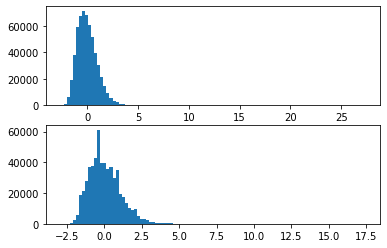

In [16]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(VIEW_1hot_encoded_wout_true_v)
scaled_test = scaler.transform(VIEW_1hot_encoded_test_wout_true_v)
pyplot.subplot(211)
pyplot.hist(scaled_train[:, -1], bins=100)
pyplot.subplot(212)
pyplot.hist(scaled_test[:, -1], bins= 100)

In [35]:
print(scaled_train.base is VIEW_1hot_encoded_wout_true_v)
print(scaled_test.base is VIEW_1hot_encoded_wout_true_v)
print(scaled_train.shape)
print(scaled_test.shape)

x_train_list = []
y_train_list = []

x_test_list = []
y_test_list = []

num_of_inds = scaled_train.shape[0]//28
print("Number of individuals: ", num_of_inds)

ground_truth= np.empty((0, 32))
naive = np.empty((0, 32))

start_time = time.time()
for i in range(num_of_inds): #num_of_inds
    ind_train = np.copy(scaled_train[(i*28):((i+1)*28), :])
    ind_train_x = np.copy(ind_train[0:8, :])
    z_pad = np.zeros((12, 32)) #changed from 12 to 20 timesteps
    ind_train_x = np.append(ind_train_x, z_pad, axis=0)
    #print(ind_train.base is z_pad)
    x_train_list.append(ind_train_x)
    y_train_list.append(ind_train[8:, -9:])
    ground_truth = np.append(ground_truth, ind_train, axis=0)
    #print("Ground truth check: ", ground_truth.base is ind_v)
    ind_test = np.copy(scaled_test[(i*28):((i+1)*28), :])
    ind_test_x = np.copy(ind_test[0:8, :])
    z_pad = np.zeros((12, 32)) #changed from 12 to 20 timesteps
    ind_test_x = np.append(ind_test_x, z_pad, axis=0)
    x_test_list.append(ind_test_x)
    #y_test_list.append(ind_test[8:, -9:])
    naive = np.append(naive, ind_test, axis=0)
    #print("Niave check: ", naive.base is ind_v)
    if i % 1000 == 0:
        print("Iteration: ", str(i))
print("Time to build train test data: ", time.time() - start_time)
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

False
False
(571480, 32)
(571480, 32)
Number of individuals:  20410
Iteration:  0
Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Time to build train test data:  397.1071848869324
(20410, 20, 32)
(20410, 20, 9)
(20410, 20, 32)
(0,)


In [56]:
#import keras
#keras.backend.clear_session()
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

2041
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 5s - loss: 0.6653 - val_loss: 0.6479

Epoch 00001: val_loss improved from inf to 0.64795, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 2/50
 - 2s - loss: 0.6438 - val_loss: 0.6400

Epoch 00002: val_loss improved from 0.64795 to 0.63997, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 3/50
 - 2s - loss: 0.6386 - val_loss: 0.6369

Epoch 00003: val_loss improved from 0.63997 to 0.63689, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 4/50
 - 2s - loss: 0.6355 - val_loss: 0.6338

Epoch 00004: val_loss improved from 0.63689 to 0.63380, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 5/50
 - 2s - loss: 0.6324 - val_loss: 0.6307

Epoch 00005: val_loss improved from 0.63380 to 0.63068, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 6/50
 - 2s - loss: 0.6307 - val_loss: 0.6288

Epoch 00006: val_loss improved from 0.63068 to 0.62882, saving model to weightsDenseMLP8to20fold1.hdf5
Epoch 7/50
 - 2s - l

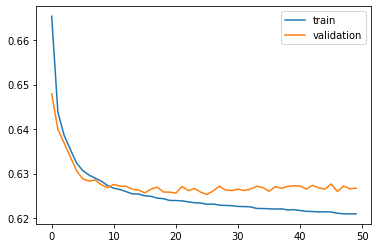

Time to train LSTM:  87.40047645568848
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  89.96022462844849
End of fold 1:  90.0005853176117
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6667 - val_loss: 0.6493

Epoch 00001: val_loss improved from inf to 0.64933, saving model to weightsDenseMLP8to20fold2.hdf5
Epoch 2/50
 - 2s - loss: 0.6452 - val_loss: 0.6412

Epoch 00002: val_loss improved from 0.64933 to 0.64125, saving model to weightsDenseMLP8to20fold2.hdf5
Epoch 3/50
 - 2s - loss: 0.6402 - val_loss: 0.6360

Epoch 00003: val_loss improved from 0.64125 to 0.63595, saving model to weightsDenseMLP8to20fold2.hdf5
Epoch 4/50
 - 2s - loss: 0.6373 - val_loss: 0.6355

Epoch 00004: val_loss improved from 0.63595 to 0.63547, saving model to weightsDenseMLP8to20fold2.hdf5
Epoch 5/50
 - 2s - loss: 0.6341 - val_loss: 0.6312

Epoch 00005: val_loss improved from 0.63547 to 0.63121, saving model to weightsDenseMLP8to

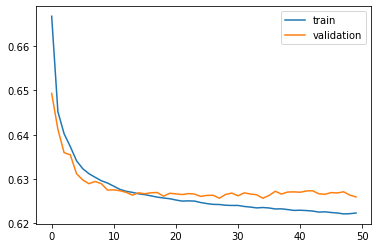

Time to train LSTM:  88.90218591690063
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  91.50211834907532
End of fold 2:  181.53178453445435
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6663 - val_loss: 0.6480

Epoch 00001: val_loss improved from inf to 0.64799, saving model to weightsDenseMLP8to20fold3.hdf5
Epoch 2/50
 - 2s - loss: 0.6441 - val_loss: 0.6403

Epoch 00002: val_loss improved from 0.64799 to 0.64030, saving model to weightsDenseMLP8to20fold3.hdf5
Epoch 3/50
 - 2s - loss: 0.6389 - val_loss: 0.6361

Epoch 00003: val_loss improved from 0.64030 to 0.63609, saving model to weightsDenseMLP8to20fold3.hdf5
Epoch 4/50
 - 2s - loss: 0.6355 - val_loss: 0.6323

Epoch 00004: val_loss improved from 0.63609 to 0.63230, saving model to weightsDenseMLP8to20fold3.hdf5
Epoch 5/50
 - 2s - loss: 0.6329 - val_loss: 0.6306

Epoch 00005: val_loss improved from 0.63230 to 0.63060, saving model to weightsDenseMLP8

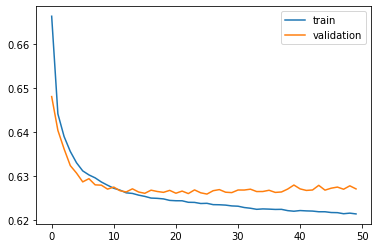

Time to train LSTM:  87.30921149253845
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  90.01691842079163
End of fold 3:  271.58231806755066
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6648 - val_loss: 0.6489

Epoch 00001: val_loss improved from inf to 0.64887, saving model to weightsDenseMLP8to20fold4.hdf5
Epoch 2/50
 - 2s - loss: 0.6431 - val_loss: 0.6415

Epoch 00002: val_loss improved from 0.64887 to 0.64149, saving model to weightsDenseMLP8to20fold4.hdf5
Epoch 3/50
 - 2s - loss: 0.6383 - val_loss: 0.6377

Epoch 00003: val_loss improved from 0.64149 to 0.63769, saving model to weightsDenseMLP8to20fold4.hdf5
Epoch 4/50
 - 2s - loss: 0.6348 - val_loss: 0.6347

Epoch 00004: val_loss improved from 0.63769 to 0.63468, saving model to weightsDenseMLP8to20fold4.hdf5
Epoch 5/50
 - 2s - loss: 0.6320 - val_loss: 0.6307

Epoch 00005: val_loss improved from 0.63468 to 0.63068, saving model to weightsDenseMLP8

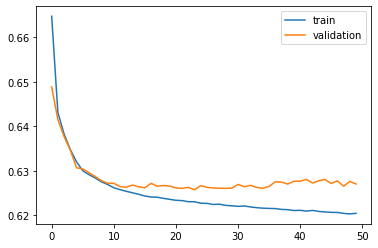

Time to train LSTM:  89.23732995986938
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  91.98855423927307
End of fold 4:  363.6114082336426
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6644 - val_loss: 0.6481

Epoch 00001: val_loss improved from inf to 0.64812, saving model to weightsDenseMLP8to20fold5.hdf5
Epoch 2/50
 - 2s - loss: 0.6427 - val_loss: 0.6416

Epoch 00002: val_loss improved from 0.64812 to 0.64158, saving model to weightsDenseMLP8to20fold5.hdf5
Epoch 3/50
 - 2s - loss: 0.6375 - val_loss: 0.6377

Epoch 00003: val_loss improved from 0.64158 to 0.63771, saving model to weightsDenseMLP8to20fold5.hdf5
Epoch 4/50
 - 2s - loss: 0.6337 - val_loss: 0.6340

Epoch 00004: val_loss improved from 0.63771 to 0.63398, saving model to weightsDenseMLP8to20fold5.hdf5
Epoch 5/50
 - 2s - loss: 0.6311 - val_loss: 0.6301

Epoch 00005: val_loss improved from 0.63398 to 0.63010, saving model to weightsDenseMLP8t

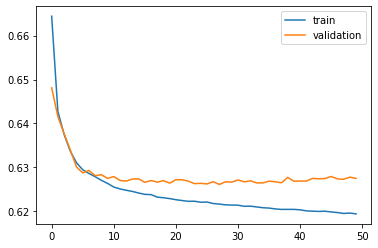

Time to train LSTM:  89.91176271438599
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  92.74241900444031
End of fold 5:  456.40217089653015
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6653 - val_loss: 0.6507

Epoch 00001: val_loss improved from inf to 0.65071, saving model to weightsDenseMLP8to20fold6.hdf5
Epoch 2/50
 - 2s - loss: 0.6428 - val_loss: 0.6422

Epoch 00002: val_loss improved from 0.65071 to 0.64220, saving model to weightsDenseMLP8to20fold6.hdf5
Epoch 3/50
 - 2s - loss: 0.6378 - val_loss: 0.6392

Epoch 00003: val_loss improved from 0.64220 to 0.63917, saving model to weightsDenseMLP8to20fold6.hdf5
Epoch 4/50
 - 2s - loss: 0.6346 - val_loss: 0.6333

Epoch 00004: val_loss improved from 0.63917 to 0.63326, saving model to weightsDenseMLP8to20fold6.hdf5
Epoch 5/50
 - 2s - loss: 0.6320 - val_loss: 0.6339

Epoch 00005: val_loss did not improve from 0.63326
Epoch 6/50
 - 2s - loss: 0.6300 - val

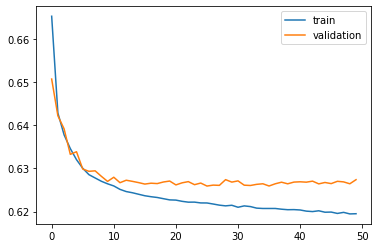

Time to train LSTM:  90.79978203773499
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  93.69197273254395
End of fold 6:  550.1470348834991
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6660 - val_loss: 0.6488

Epoch 00001: val_loss improved from inf to 0.64884, saving model to weightsDenseMLP8to20fold7.hdf5
Epoch 2/50
 - 2s - loss: 0.6442 - val_loss: 0.6406

Epoch 00002: val_loss improved from 0.64884 to 0.64061, saving model to weightsDenseMLP8to20fold7.hdf5
Epoch 3/50
 - 2s - loss: 0.6393 - val_loss: 0.6382

Epoch 00003: val_loss improved from 0.64061 to 0.63819, saving model to weightsDenseMLP8to20fold7.hdf5
Epoch 4/50
 - 2s - loss: 0.6356 - val_loss: 0.6345

Epoch 00004: val_loss improved from 0.63819 to 0.63450, saving model to weightsDenseMLP8to20fold7.hdf5
Epoch 5/50
 - 2s - loss: 0.6331 - val_loss: 0.6315

Epoch 00005: val_loss improved from 0.63450 to 0.63151, saving model to weightsDenseMLP8t

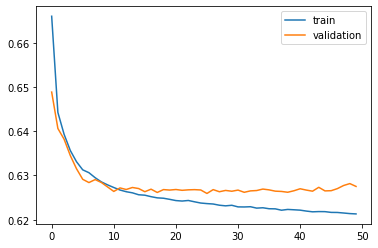

Time to train LSTM:  90.62562966346741
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  93.48956370353699
End of fold 7:  643.6937379837036


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f231d1ed400>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 6s - loss: 0.6666 - val_loss: 0.6503

Epoch 00001: val_loss improved from inf to 0.65034, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 2/50
 - 2s - loss: 0.6447 - val_loss: 0.6416

Epoch 00002: val_loss improved from 0.65034 to 0.64160, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 3/50
 - 2s - loss: 0.6394 - val_loss: 0.6361

Epoch 00003: val_loss improved from 0.64160 to 0.63615, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 4/50
 - 2s - loss: 0.6363 - val_loss: 0.6338

Epoch 00004: val_loss improved from 0.63615 to 0.63384, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 5/50
 - 2s - loss: 0.6336 - val_loss: 0.6323

Epoch 00005: val_loss improved from 0.63384 to 0.63226, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 6/50
 - 2s - loss: 0.6315 - val_loss: 0.6301

Epoch 00006: val_loss improved from 0.63226 to 0.63012, saving model to weightsDenseMLP8to20fold8.hdf5
Epoch 7/50
 - 2s - loss: 

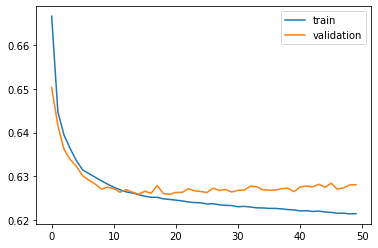

Time to train LSTM:  93.17663216590881
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  96.20221996307373
End of fold 8:  739.9638476371765
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 7s - loss: 0.6658 - val_loss: 0.6531

Epoch 00001: val_loss improved from inf to 0.65313, saving model to weightsDenseMLP8to20fold9.hdf5
Epoch 2/50
 - 2s - loss: 0.6440 - val_loss: 0.6428

Epoch 00002: val_loss improved from 0.65313 to 0.64285, saving model to weightsDenseMLP8to20fold9.hdf5
Epoch 3/50
 - 2s - loss: 0.6388 - val_loss: 0.6384

Epoch 00003: val_loss improved from 0.64285 to 0.63844, saving model to weightsDenseMLP8to20fold9.hdf5
Epoch 4/50
 - 2s - loss: 0.6355 - val_loss: 0.6344

Epoch 00004: val_loss improved from 0.63844 to 0.63437, saving model to weightsDenseMLP8to20fold9.hdf5
Epoch 5/50
 - 2s - loss: 0.6325 - val_loss: 0.6317

Epoch 00005: val_loss improved from 0.63437 to 0.63170, saving model to weightsDenseMLP8t

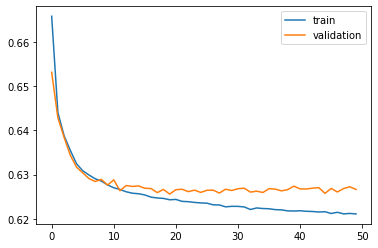

Time to train LSTM:  92.10690665245056
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  95.1032612323761
End of fold 9:  835.1379067897797
Train on 16532 samples, validate on 1837 samples
Epoch 1/50
 - 7s - loss: 0.6652 - val_loss: 0.6437

Epoch 00001: val_loss improved from inf to 0.64369, saving model to weightsDenseMLP8to20fold10.hdf5
Epoch 2/50
 - 2s - loss: 0.6435 - val_loss: 0.6325

Epoch 00002: val_loss improved from 0.64369 to 0.63252, saving model to weightsDenseMLP8to20fold10.hdf5
Epoch 3/50
 - 2s - loss: 0.6383 - val_loss: 0.6322

Epoch 00003: val_loss improved from 0.63252 to 0.63223, saving model to weightsDenseMLP8to20fold10.hdf5
Epoch 4/50
 - 2s - loss: 0.6352 - val_loss: 0.6292

Epoch 00004: val_loss improved from 0.63223 to 0.62924, saving model to weightsDenseMLP8to20fold10.hdf5
Epoch 5/50
 - 2s - loss: 0.6326 - val_loss: 0.6275

Epoch 00005: val_loss improved from 0.62924 to 0.62754, saving model to weightsDenseML

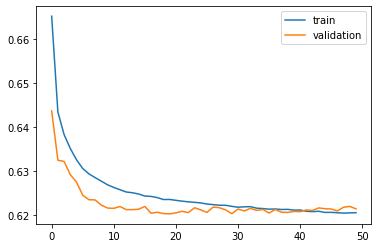

Time to train LSTM:  92.2327516078949
inv_y x and inv_yhat x are the same
inv_y x and inv_naive x are the same
Time to train and test LSTM:  95.31533885002136
End of fold 10:  930.5298655033112
Entire process took:  930.5301177501678
RMSE LSTM List
[0.5782503889727895, 0.5787837558658269, 0.5766544047491344, 0.5835333232020277, 0.6030059302459172, 0.5868515687719775, 0.5819104032163231, 0.5795027130363286, 0.5894579487999337, 0.5911503758376351]
RMSE Naive List
[0.5037034801818228, 0.49879482772335887, 0.4891138354751703, 0.5179748406050775, 0.5296471740749095, 0.5210355016603438, 0.5154034352618261, 0.5135971062352568, 0.5157057128044397, 0.5150722150971082]
(571480, 32)
(571480, 32)
(571480, 32)


In [36]:
num_per_fold = num_of_inds//10
print(num_per_fold)

rmse_lstm_list = []
rmse_naive_list = []

complete_inv_y = np.empty((0, 32))
complete_inv_lstm = np.empty((0, 32))
complete_inv_naive = np.empty((0, 32))

start_time = time.time()
for f in range(10):
    start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:start, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train1_x, train2_x, axis=0) #new obj
    train1_y = y_train[:start, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train1_y, train2_y, axis=0)
    
    test_x_lstm = x_test[start:end, ]
    #test_y_lstm = y_test[start:end, ]
    # time training
    start_time_inner = time.time()
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        '''
        model.add(CuDNNLSTM(512, return_sequences=False,
                            input_shape=(8, 32)))
        model.add(RepeatVector(20))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(TimeDistributed(Dense(9)))
        model.compile(loss='mae', optimizer='adam')
        '''
        '''
        model.add(CuDNNLSTM(512, return_sequences=True,
                             input_shape=(20, 32)))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(TimeDistributed(Dense(9)))
        model.compile(loss='mae', optimizer='adam')
        '''
        '''
        model.add(CuDNNLSTM(512, return_sequences=True,
                            input_shape=(28, 32)))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(CuDNNLSTM(512, return_sequences=True))
        model.add(Lambda(lambda x : x[:, -20:, :]))
        model.add(TimeDistributed(Dense(9)))
        model.compile(loss='mae', optimizer='adam')
        '''
        model.add(Dense(512, activation='relu', input_shape=(20, 32)))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        #model.add(Dense(20))
        model.add(TimeDistributed(Dense(9)))
        model.compile(loss='mae', optimizer='adam')
        weight = "weightsDenseMLP8to20fold" + str(f+1) + ".hdf5" #"Test"+str(f+1)+".hdf5" 
        checkpointer = ModelCheckpoint(filepath=weight,
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=32,
                            epochs=50, validation_split=0.1, 
                            callbacks=[checkpointer], verbose=2, 
                            shuffle=False) 
    
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
    #######################################
    # LSTM Prediction
    #######################################
    model.load_weights(weight)
    yhat = np.empty((0, 32))
    yhat_pred = model.predict(test_x_lstm)
    fold_naive = naive[(start*28):(end*28), :]
    for i in range(num_per_fold):
        ind_pred = np.copy(fold_naive[(i*28):((i+1)*28), :])
        ind_pred[8:, -9:] = yhat_pred[i]
        yhat = np.append(yhat, ind_pred, axis=0)
    inv_yhat = scaler.inverse_transform(yhat)
    inv_y = scaler.inverse_transform(ground_truth[(start*28):(end*28), :])
    inv_naive = scaler.inverse_transform(naive[(start*28):(end*28), :])
    if np.array_equal(inv_y[:, :-9], inv_yhat[:, :-9]):
        print("inv_y x and inv_yhat x are the same")
    else:
        print("inv_y x and inv_yhat x are not the same")
    if np.array_equal(inv_y[:, :-9], inv_naive[:, :-9]):
        print("inv_y x and inv_naive x are the same")
    else:
        print("inv_y x and inv_naive x are not the same")
    print("Time to train and test LSTM: ", time.time() - start_time_inner)
    rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -9:], inv_yhat[:, -9:]))
    rmse_naive = math.sqrt(mean_squared_error(inv_y[:, -9:], inv_naive[:, -9:]))
    rmse_lstm_list.append(rmse_lstm)
    rmse_naive_list.append(rmse_naive)
    
    complete_inv_y = np.append(complete_inv_y, inv_y, axis=0)
    complete_inv_lstm = np.append(complete_inv_lstm, inv_yhat, axis=0)
    complete_inv_naive = np.append(complete_inv_naive, inv_naive, axis=0)
    
    print("End of fold "+str(f+1)+ ": ", time.time()-start_time)
    
print("Entire process took: ", time.time() - start_time)
print("RMSE LSTM List")
print(rmse_lstm_list)
print("RMSE Naive List")
print(rmse_naive_list)
print(complete_inv_y.shape)
print(complete_inv_lstm.shape)
print(complete_inv_naive.shape)

In [37]:
print(complete_inv_y.shape)
print(complete_inv_lstm.shape)
print(complete_inv_naive.shape)

(571480, 32)
(571480, 32)
(571480, 32)


In [38]:
#########################################
# map number id back to unique strings
#########################################
print(complete_inv_y.shape)
print(complete_inv_lstm.shape)
print(complete_inv_y[0:20, 0])

num_to_ID = {v: k for k, v in ID_to_num.items()}
complete_inv_y = np.array(complete_inv_y, dtype = np.object)
complete_inv_lstm = np.array(complete_inv_lstm, dtype = np.object)
complete_inv_naive = np.array(complete_inv_naive, dtype=np.object)

for i in range(len(complete_inv_y)):#len(complete_inv_y)
    complete_inv_y[i, 0] = num_to_ID[round(complete_inv_y[i, 0])]
    complete_inv_lstm[i, 0] = num_to_ID[round(complete_inv_lstm[i, 0])]
    complete_inv_naive[i, 0] = num_to_ID[round(complete_inv_naive[i, 0])]
print(complete_inv_y[0:20, 0])
print(complete_inv_lstm[0:20, 0])
print(complete_inv_naive[0:20, 0])

(571480, 32)
(571480, 32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK']
['STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK']
['STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NP

In [39]:
VIEW_1hot_encoded_v = np.array(VIEW_1hot_encoded_v, dtype = np.object)

print(VIEW_1hot_encoded_v[0:50, 0])

for i in range(len(VIEW_1hot_encoded_v)):
    VIEW_1hot_encoded_v[i, 0] = num_to_ID[round(VIEW_1hot_encoded_v[i, 0])]
print(VIEW_1hot_encoded_v[0:20, 0])

['STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK' 'STb77b2NPhNK'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz']


TypeError: type str doesn't define __round__ method

In [26]:
complete_inv_y_df = pd.DataFrame(complete_inv_y)
complete_inv_y_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H', #'INTERRUPTION', 'POST_INTERRUPTION',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_y_df.to_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_MLP_standardised_20410inds_y.csv', sep=",")
complete_inv_lstm_df = pd.DataFrame(complete_inv_lstm)
complete_inv_lstm_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H', #'INTERRUPTION', 'POST_INTERRUPTION',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_lstm_df.to_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_MLP_standardised_20410inds_yhat.csv', sep=",")
complete_inv_naive_df = pd.DataFrame(complete_inv_naive)
complete_inv_naive_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H', #'INTERRUPTION', 'POST_INTERRUPTION',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_naive_df.to_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_MLP_standardised_20410inds_naive.csv', sep=",")


In [40]:
print(VIEW_1hot_encoded_v.shape)
print(np.unique(VIEW_1hot_encoded_v[:, -11]))

print(ind_id)
print(complete_inv_y.shape)
print(complete_inv_lstm.shape)
print(complete_inv_naive.shape)

(571480, 37)
[0 1]
STJ4DA3khi2A
(571480, 32)
(571480, 32)
(571480, 32)


In [41]:
#################################
# data check
# y should match view (ground truth)
#################################
ind_id = complete_inv_y[0, 0]
print(ind_id)
ind_y = complete_inv_y[complete_inv_y[:, 0] == ind_id]
ind_lstm = complete_inv_lstm[complete_inv_lstm[:, 0] == ind_id]
ind_naive = complete_inv_naive[complete_inv_naive[:, 0] == ind_id]
ind_view = VIEW_1hot_encoded_v[VIEW_1hot_encoded_v[:, 0] == ind_id]
print(ind_y.shape)
print(ind_lstm.shape)
print(ind_naive.shape)
print(ind_view.shape)
print(np.around(ind_lstm[:, -9:].astype(np.double), decimals=2))
print(np.around(ind_naive[:, -9:].astype(np.double), decimals=2))
print(np.around(ind_y[:, -9:].astype(np.double), decimals=2))
print(np.around(ind_view[:, -14:-5].astype(np.double), decimals=2))

STb77b2NPhNK
(28, 32)
(28, 32)
(28, 32)
(28, 37)
[[ 0.    0.    0.    0.    2.18  2.51  0.97  5.16  2.4 ]
 [ 0.    0.    0.    0.    2.18  2.49  1.02  5.14  2.4 ]
 [ 0.    0.    0.    0.    2.17  2.46  1.08  5.13  2.4 ]
 [ 0.    0.    0.    0.    2.17  2.44  1.13  5.12  2.4 ]
 [ 0.    0.    0.    0.    2.16  2.41  1.18  5.11  2.4 ]
 [ 0.    0.    0.    1.    2.16  2.4   1.2   5.1   2.4 ]
 [ 0.    0.    0.    0.    2.16  2.4   1.2   5.1   2.4 ]
 [ 0.    0.    0.    0.    2.16  2.4   1.2   5.1   2.4 ]
 [-0.01  0.   -0.    0.    2.05  2.9   1.04  5.54  2.67]
 [-0.01  0.   -0.    0.    2.05  2.9   1.05  5.55  2.67]
 [-0.01  0.   -0.    0.    2.05  2.9   1.08  5.55  2.68]
 [-0.01  0.   -0.    0.    2.04  2.9   1.1   5.56  2.69]
 [-0.01  0.   -0.    0.    2.03  2.89  1.12  5.55  2.69]
 [-0.    0.   -0.    0.    2.01  2.95  1.13  5.59  2.73]
 [-0.01  0.   -0.    0.    2.03  2.87  1.13  5.53  2.69]
 [-0.01  0.   -0.    0.    2.01  2.87  1.14  5.53  2.7 ]
 [ 0.    0.    0.    0.    1.22  2.6   

In [42]:
# check to see if data order of y, yhat and naive are the same
print(np.array_equal(complete_inv_y[:, 0], complete_inv_lstm[:, 0]))
print(np.array_equal(complete_inv_y[:, 0], complete_inv_naive[:, 0]))
print(len(complete_inv_y)//10)
print(len(complete_inv_y)//28)

True
True
57148
20410


In [46]:
#######################################
# Error calculation
#######################################
value_indicating_test = max(np.unique(VIEW_1hot_encoded_v[:, -11]))
value_indicating_no_test = min(np.unique(VIEW_1hot_encoded_v[:, -11]))

empty_list_count = 0
empty_list_IDs = []
TCHDL_list = []
y_list = []
LSTM_list = []
naive_list = []
ten_fold_idx = []
for i in range(len(complete_inv_y)//28):#len(complete_inv_y)//28
    ind_id = complete_inv_y[i*28, 0]
    ind_y = copy.deepcopy(complete_inv_y[(i*28):((i+1)*28), :])
    ind_lstm = copy.deepcopy(complete_inv_lstm[(i*28):((i+1)*28), :])
    ind_naive = copy.deepcopy(complete_inv_naive[(i*28):((i+1)*28), :])
    ind_truth = copy.deepcopy(VIEW_1hot_encoded_v[VIEW_1hot_encoded_v[:, 0] == ind_id])
    #print(ind_y.shape)
    #print(ind_lstm.shape)
    #print(ind_naive.shape)
    #print(ind_truth.shape)
    for j in range(8, 28): 
        if ind_truth[j, -11] == value_indicating_test:
            if len(ind_truth[j, -1]) > 4:
                #TCHDL_s ind_truth[j, -1][1:-1].split(", ")
                TCHDLs = [float(TCHDL) for TCHDL in ind_truth[j, -1][1:-1].split(", ")]
                mean_TCHDL = sum(TCHDLs)/len(TCHDLs)
                TCHDL_list.append(mean_TCHDL)
                y_list.append(ind_y[j, -1])
                LSTM_list.append(ind_lstm[j, -1])
                naive_list.append(ind_naive[j, -1])
            else:
                empty_list_count += 1
                empty_list_IDs.append(ind_id)
    if i % (len(complete_inv_y)//280) == 0:
        ten_fold_idx.append(len(y_list))
        print("Iteration: ", str(i))
print(empty_list_count)
print(empty_list_IDs)
print(len(TCHDL_list))
print(len(y_list))
print(len(LSTM_list))
print(len(naive_list))
print("Ten fold indices: ")
print(ten_fold_idx)
              
rmse_y = math.sqrt(mean_squared_error(TCHDL_list, y_list))
rmse_lstm = math.sqrt(mean_squared_error(TCHDL_list, LSTM_list))
rmse_naive = math.sqrt(mean_squared_error(TCHDL_list, naive_list))
print("RMSE y", rmse_y)
print("RMSE yhat", rmse_lstm)
print("RMSE naive", rmse_naive)           

Iteration:  0
Iteration:  2041
Iteration:  4082
Iteration:  6123
Iteration:  8164
Iteration:  10205
Iteration:  12246
Iteration:  14287
Iteration:  16328
Iteration:  18369
669
['STUCCthPefrX', 'STuRHr2yupXt', 'ST5764rA5290', 'SThyOOaoMYZx', 'SThyOOaoMYZx', 'SThyOOaoMYZx', 'STPuZAm890pU', 'STE6dH0VdLfN', 'ST6Uk4FixBDO', 'STfbGCbYQUym', 'STu3NGCz43DE', 'ST5hvtZPtbWY', 'STHSAVxciQIb', 'STUefh119teP', 'STmJzBjhcURi', 'STZzTH2VvIHJ', 'STIrTGqpF9ds', 'STCMWxaLiqtg', 'STCMWxaLiqtg', 'STOv6AEEkImT', 'STaNNg78DsMQ', 'STaKEoYqML1D', 'STaKEoYqML1D', 'STpuEPjj8V2u', 'STeklPiEHISP', 'STeklPiEHISP', 'STgEndY94qZP', 'STgEndY94qZP', 'STiE2mHFntVq', 'STBlFOhU3usc', 'STBlFOhU3usc', 'STABMNp3SiCR', 'STLr3MlmVijD', 'STvpyqlgFeJs', 'STDhghGwTEPt', 'STMEHm5K9v3G', 'STM0JfcfGWRU', 'STlpyb4BhXIZ', 'ST1yMuUo9Ltr', 'STCQ0ieXUBsa', 'SThPXQzfJQAD', 'STXB2weClIFb', 'STIZCYa618ys', 'STQdX2XmxyPb', 'STQdX2XmxyPb', 'STymmYZ1lyjh', 'STymmYZ1lyjh', 'STymmYZ1lyjh', 'STPZ4eTDlku9', 'ST8by6gxQTsP', 'ST9Fy4xoJdzt', 'STitj1

In [47]:
import scipy.stats as st

ten_fold_idx[0] = 0
ten_fold_idx.append(len(y))

rmse_y_list = []
rmse_lstm_list = []
rmse_naive_list = []
for i in range(len(ten_fold_idx)-1):
    start = ten_fold_idx[i]
    end = ten_fold_idx[(i+1)]
    rmse_y = math.sqrt(mean_squared_error(TCHDL_list[start:end], y_list[start:end]))
    rmse_lstm = math.sqrt(mean_squared_error(TCHDL_list[start:end], LSTM_list[start:end]))
    rmse_naive = math.sqrt(mean_squared_error(TCHDL_list[start:end], naive_list[start:end]))
    rmse_y_list.append(rmse_y)
    rmse_lstm_list.append(rmse_lstm)
    rmse_naive_list.append(rmse_naive)
    
y_forecast_cf = st.t.interval(0.95, len(rmse_y_list)-1, 
                              loc=np.mean(rmse_y_list), 
                              scale=st.sem(rmse_y_list)) 
lstm_forecast_cf = st.t.interval(0.95, len(rmse_lstm_list)-1, 
                              loc=np.mean(rmse_lstm_list), 
                              scale=st.sem(rmse_lstm_list)) 
naive_forecast_cf = st.t.interval(0.95, len(rmse_naive_list)-1, 
                              loc=np.mean(rmse_naive_list), 
                              scale=st.sem(rmse_naive_list)) 
print("y confidence interval: ", y_forecast_cf)
print("lstm confidence interval: ", lstm_forecast_cf)
print("naive confidence interval: ", naive_forecast_cf)

#t test 
print("T test LSTM vs naive")
print(scipy.stats.ttest_ind(rmse_lstm_list, rmse_naive_list))

y confidence interval:  (0.2778840291977086, 0.29592587059344544)
lstm confidence interval:  (0.9091808606151404, 0.9397951097578865)
naive confidence interval:  (0.9116286463786151, 0.9528952377432197)
T test LSTM vs naive
Ttest_indResult(statistic=-0.6845094682516496, pvalue=0.5023727243300005)


In [107]:
print(rmse_naive_list)
#ten_fold_idx = ten_fold_idx[:-1]
#print(ten_fold_idx)

[0.9316485404363029, 0.9120434766102605, 0.867487365430648, 0.9604291862284056, 0.9677482706206675, 0.9525116648580602, 0.9481711420322491, 0.921893575153941, 0.9252513635392146, 0.9354348356994249]


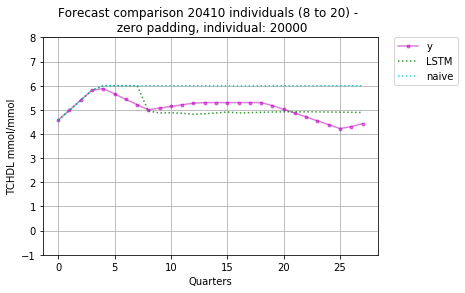

In [73]:
#################################
# plot examples from data
#################################
# sample individual

idx = 20000 #90 140 and 40
ind_y = complete_inv_y[(idx*28):((idx+1)*28), -1]
ind_lstm = complete_inv_lstm[(idx*28):((idx+1)*28), -1]
ind_naive = complete_inv_naive[(idx*28):((idx+1)*28), -1]

quarters = complete_inv_y[(idx*28):((idx+1)*28), 1]

fig, ax = pyplot.subplots()
#fig.set_figheight(8)
#fig.set_figwidth(15)
ax.plot(quarters, ind_y, '.-', color='m', alpha=0.5, label="y")
ax.plot(quarters, ind_lstm, ':', color='g', alpha=0.8, label="LSTM")
ax.plot(quarters, ind_naive, ':', color='c', alpha=0.8, label="naive")
ax.set(xlabel='Quarters',
       ylabel='TCHDL mmol/mmol', 
       Title='Forecast comparison 20410 individuals (8 to 20) - \n zero padding, individual: ' + str(idx))
ax.set_ylim([-1, 8])
ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#fig.savefig('/home/whsu014/plots/LSTM_8to20_zero_pad_20410inds_ind' + str(idx) + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pyplot.show()

 STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
 A, B, C, D, E, H
 SBP, DBP, SBP2, DBP2,
 SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
 GEN_LIPID, RENAL, HX_DIABETES_YR
 STATINS, ATORVASTATIN, SIMVASTATIN, 
 TEST, HDL, LDL, TRI, TCL, TCHDL
 TRUE_HDL, TRUE_LDL, TRUE_TRI, TRUE_TCL, TRUE_TCHDL
 
 
VIEW_sub_v1 = VIEW_sub_v[:, [0,2,3,5,6]] # Demographic variables + QUARTERS


VIEW_sub_v2 = VIEW_sub_v[:, [13,14,15]] # STATINS  PHH


VIEW_sub_v3 = VIEW_sub_v[:, [21,22,23,24,25,26,27,28,29,30,31,32]] # PREDICT variables


VIEW_sub_v4 = VIEW_sub_v[:, [7,8,9,10,11,12]] # INTERPOLATED CHOLESTEROLS TESTSAFE


VIEW_sub_v5 = VIEW_sub_v[:, [16,17,18,19,20]] # TRUE CHOLESTEROLS

In [82]:
print(VIEW_1hot_encoded_v.shape)
print(VIEW_1hot_encoded_v.shape[0]//28)
idx = 800
print(np.around(VIEW_1hot_encoded_v[(idx*28):((idx+1)*28), [1,26,27,28,29,30,31]].astype(np.double), decimals=3))#statins 23,24,25, true values 32,33,34,35,36

(571592, 37)
20414
[[ 0.     0.     1.31   1.735  0.91   3.445  2.625]
 [ 1.     0.     1.275  1.788  0.875  3.462  2.712]
 [ 2.     0.     1.24   1.84   0.84   3.48   2.8  ]
 [ 3.     0.     1.205  1.893  0.805  3.498  2.888]
 [ 4.     1.     1.224  2.291  0.8    3.916  3.169]
 [ 5.     0.     1.253  2.743  0.8    4.395  3.479]
 [ 6.     0.     1.281  3.194  0.8    4.875  3.79 ]
 [ 7.     1.     1.3    3.15   0.975  4.9    3.775]
 [ 8.     1.     1.299  2.117  1.493  4.015  3.114]
 [ 9.     0.     1.279  2.628  1.289  4.458  3.523]
 [10.     0.     1.258  3.14   1.084  4.901  3.932]
 [11.     1.     1.234  3.408  0.876  5.084  4.132]
 [12.     1.     1.184  2.04   0.788  3.572  2.988]
 [13.     0.     1.16   2.19   1.118  3.842  3.318]
 [14.     0.     1.136  2.34   1.448  4.112  3.648]
 [15.     0.     1.112  2.49   1.778  4.382  3.978]
 [16.     1.     1.215  1.753  0.815  3.363  2.739]
 [17.     0.     1.246  2.097  0.908  3.769  2.989]
 [18.     0.     1.277  2.441  1.002  4.176  

In [83]:
print(VIEW_1hot_encoded_v[(idx*28):((idx+1)*28), [1,36]])

[[0 '[]']
 [1 '[]']
 [2 '[]']
 [3 '[]']
 [4 '[2.9]']
 [5 '[]']
 [6 '[]']
 [7 '[4.0]']
 [8 '[3.1]']
 [9 '[]']
 [10 '[]']
 [11 '[4.3]']
 [12 '[2.9]']
 [13 '[]']
 [14 '[]']
 [15 '[]']
 [16 '[4.0, 2.7]']
 [17 '[]']
 [18 '[]']
 [19 '[]']
 [20 '[3.5, 2.7]']
 [21 '[]']
 [22 '[]']
 [23 '[]']
 [24 '[4.9]']
 [25 '[]']
 [26 '[]']
 [27 '[]']]


In [2]:
y_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_y.csv')
lstm_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_yhat.csv') 
naive_df = pd.read_csv('/home/whsu014/data/LSTM_TCHDL_8to20_experiment_zero_pad_standardised_20410inds_naive.csv')

In [4]:
print(y_df.shape)
print(lstm_df.shape)
print(naive_df.shape)
print(y_df.columns)
print(lstm_df.columns)
print(naive_df.columns)
y = y_df.iloc[:, 1:].values
lstm = lstm_df.iloc[:, 1:].values
naive = naive_df.iloc[:, 1:].values
# check if the arrays (order of samples)
# are the same
print(np.array_equal(y[:, 0], lstm[:, 0]))
print(np.array_equal(y[:, 0], naive[:, 0]))

(571480, 33)
(571480, 33)
(571480, 33)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'ETHN_D', 'ETHN_E', 'ETHN_H', 'SBP',
       'DBP', 'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
       'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
       'STATINS', 'ATORVASTATIN', 'SIMVASTATIN', 'TEST', 'HDL', 'LDL', 'TRI',
       'TCL', 'TCHDL'],
      dtype='object')
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'ETHN_D', 'ETHN_E', 'ETHN_H', 'SBP',
       'DBP', 'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
       'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
       'STATINS', 'ATORVASTATIN', 'SIMVASTATIN', 'TEST', 'HDL', 'LDL', 'TRI',
       'TCL', 'TCHDL'],
      dtype='object')
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'E

In [11]:

print(type(y[0, 23]))
for i in range(4):
    ind_y = y[(i*28):((i+1)*28), :]
    print(np.unique(ind_y[:, 23], return_counts=True))
    print(list(ind_y[:, 23]).count(1.0))

<class 'float'>
(array([0.0], dtype=object), array([28]))
0
(array([0.0, 1.0], dtype=object), array([26,  2]))
2
(array([0.0, 1.0], dtype=object), array([27,  1]))
1
(array([0.0, 1.0], dtype=object), array([ 2, 26]))
26


In [17]:
#####################################
# Calculate adherence prediction
#####################################
# on med if >=2 1s in the first 8 quarters
# of STATINS.
# adherent if >= 16 in the last 20 quarters 
# of STATINS
lstm[:, 23] = np.around(lstm[:, 23].astype(np.double),0)

on_med_adh_pred_adh = []
on_med_adh_pred_nadh = []
on_med_nadh_pred_adh = []
on_med_nadh_pred_nadh = []

no_med_adh_pred_adh = []
no_med_adh_pred_nadh = []
no_med_nadh_pred_adh = []
no_med_nadh_pred_nadh = []

for i in range(len(y)//28):
    ind_id = y[i*28, 0]
    ind_y = y[(i*28):((i+1)*28), :]
    ind_lstm = lstm[(i*28):((i+1)*28), :]
    if list(ind_y[0:8, 23]).count(1.0) >= 2:
        if list(ind_y[8:28, 23]).count(1.0) >= 16:
            if list(ind_lstm[8:28, 23]).count(1.0) >= 16:
                on_med_adh_pred_adh.append(ind_id)
            else:
                on_med_adh_pred_nadh.append(ind_id)
        else:
            if list(ind_lstm[8:28, 23]).count(1.0) >= 16:
                on_med_nadh_pred_adh.append(ind_id)
            else:
                on_med_nadh_pred_nadh.append(ind_id)
    else:
        if list(ind_y[8:28, 23]).count(1.0) >= 16:
            if list(ind_lstm[8:28, 23]).count(1.0) >= 16:
                no_med_adh_pred_adh.append(ind_id)
            else:
                no_med_adh_pred_nadh.append(ind_id)
        else:
            if list(ind_lstm[8:28, 23]).count(1.0) >= 16:
                no_med_nadh_pred_adh.append(ind_id)
            else:
                no_med_nadh_pred_nadh.append(ind_id)
print(len(on_med_adh_pred_adh))
print(len(on_med_adh_pred_nadh))
print(len(on_med_nadh_pred_adh))
print(len(on_med_nadh_pred_nadh))
print(len(no_med_adh_pred_adh))
print(len(no_med_adh_pred_nadh))
print(len(no_med_nadh_pred_adh))
print(len(no_med_nadh_pred_nadh))

5787
305
2667
661
10
614
32
10334


# Inspect CuDNNLSTM layers
# weights and layer outputs

In [46]:

model = Sequential()
model.add(CuDNNLSTM(512, return_sequences=True,
                             input_shape=(20, 32)))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(CuDNNLSTM(512, return_sequences=True))
model.add(TimeDistributed(Dense(9)))
model.compile(loss='mae', optimizer='adam')
#model.load_weights("weights8to20foldzeropadding10.hdf5")
print(model.layers[0].trainable_weights)

[<tf.Variable 'cu_dnnlstm_10/kernel:0' shape=(32, 2048) dtype=float32_ref>, <tf.Variable 'cu_dnnlstm_10/recurrent_kernel:0' shape=(512, 2048) dtype=float32_ref>, <tf.Variable 'cu_dnnlstm_10/bias:0' shape=(4096,) dtype=float32_ref>]


In [47]:
U = model.layers[0].get_weights()[1]
print(U.shape)
print(np.around(U[0:20, :20].astype(np.double), decimals=3))

(512, 2048)
[[ 0.017 -0.008  0.006  0.027  0.013 -0.011 -0.035 -0.004  0.002 -0.023
  -0.026  0.013 -0.004  0.001 -0.022 -0.002 -0.004  0.041 -0.002 -0.034]
 [-0.039 -0.003 -0.042 -0.04   0.029  0.018 -0.004 -0.004 -0.023  0.021
   0.002  0.003  0.013  0.032 -0.004  0.001  0.002  0.008 -0.017  0.003]
 [-0.031  0.007 -0.024  0.017 -0.001  0.012 -0.036 -0.012  0.019 -0.009
   0.021  0.014 -0.018  0.031 -0.036  0.042  0.006 -0.036  0.01  -0.039]
 [ 0.023  0.024  0.001  0.015 -0.012  0.01   0.014  0.015  0.04   0.011
  -0.029 -0.033 -0.024  0.014 -0.012  0.017 -0.017  0.002 -0.011 -0.037]
 [-0.008  0.019 -0.029 -0.029 -0.001  0.005 -0.005  0.024 -0.018 -0.033
   0.007  0.004 -0.013  0.022  0.011 -0.01  -0.03  -0.059  0.035  0.016]
 [-0.     0.033  0.039 -0.005 -0.027  0.001 -0.025  0.035  0.027 -0.026
  -0.002  0.008  0.035  0.006 -0.003  0.035 -0.    -0.01  -0.022 -0.01 ]
 [ 0.014 -0.007 -0.012  0.004 -0.003 -0.011 -0.005 -0.009  0.028 -0.027
   0.008 -0.012 -0.007  0.026  0.001 -0.014  0

In [48]:
ts_x = np.array([[1,2,3,4,5],
                 [2,3,4,5,6],
                 [1,2,3,4,5],
                 [2,3,4,5,6]])
ts_y = np.array([[6,7,8,9,0],
                 [5,6,7,8,9],
                 [6,7,8,9,0],
                 [5,6,7,8,9]])
scaler = StandardScaler()
scaled_x = scaler.fit_transform(ts_x)
scaled_y = scaler.transform(ts_y)
x = np.array([scaled_x])
y = np.array([scaled_y])
print(x.shape)
print(y.shape)

(1, 4, 5)
(1, 4, 5)


In [49]:
with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
    model = Sequential()
    model.add(CuDNNLSTM(3, return_sequences=True,
                             input_shape=(4, 5)))
    model.add(TimeDistributed(Dense(5)))
    model.compile(loss='mae', optimizer='adam')
    checkpointer = ModelCheckpoint(filepath="Test.hdf5",
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True)
        
        ############################################
        # inspect U matrices <Recurrent Kernel>
        ############################################
    U = model.layers[0].get_weights()[1]
    print(U)
    history = model.fit(x, y, steps_per_epoch=1,
                            epochs=1, 
                            callbacks=[checkpointer], 
                            verbose=2, shuffle=False) 
    
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    U = model.layers[0].get_weights()[1]
    print(U)

[[ 0.2798698   0.36172447  0.05949379 -0.20187     0.48120594  0.11369793
   0.21375789 -0.29524204  0.11309183 -0.5462003  -0.18469407  0.15477161]
 [-0.3592107   0.08704434  0.22084765  0.11764143  0.20936699 -0.08805442
  -0.27466184 -0.38499013 -0.4282749   0.06893158 -0.43298307 -0.38715348]
 [-0.22790775  0.2466343   0.3342558  -0.6993317   0.08160076  0.07026763
  -0.08896469  0.3197481  -0.1479615   0.2724903  -0.02670722  0.26044422]]
Instructions for updating:
Use tf.cast instead.
Epoch 1/1


UnknownError: Fail to find the dnn implementation.
	 [[{{node cu_dnnlstm_13/CudnnRNN}}]]
	 [[{{node loss_4/mul}}]]